In [61]:
import os
import re
import json
import time
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.patches as mpatches
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Problem Statement and Research Question

What words, phrases, or ideas are most significant in predicting the sentiment of a movie review? To what extent are various models able to make accurate predictions, and which models are the best at identifying key ideas?

# Data Preprocessing

## Data Sources

We are using data from [Kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews), which consists of 50,000 movie reviews scraped from IMDB as well as whether the sentiment is positive or negative. Utilizing natural language processing (NLP), we will be attempting to create a model that can effectively distinguish between positive and negative reviews, as well as identifying the most important words or phrases in the reviews when classifying them. Finally, we will also be attempting different NLP approaches and comparing their effectiveness in order to gain a sense of the costs and benefits of various methods.


In [62]:
path = 'imdb.csv'
df = pd.read_csv(path)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [63]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
print('POSITIVE REVIEW EXAMPLES:\n')
for review in df[df.sentiment == 1].review[0:5]:
    print(review[:200] + '...\n')

print('\nNEGATIVE REVIEW EXAMPLES:\n')
for review in df[df.sentiment == 0].review[0:5]:
    print(review[:200] + '...\n')

POSITIVE REVIEW EXAMPLES:

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo...

A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece...

I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is wi...

Petter Mattei's "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, p...

Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it's not preachy or boring. It just never ge

In [65]:
df.info(memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 65.3 MB


The size of the dataset is 77.0 MB.

The reviews consist of sentences or phrases as well as line breaks which are represented by `<br />`, while the sentiments are either positive or negative; we mapped the sentiments to a binary indicator of 1 or 0, with 1 representing positive sentiment and 0 representing negative sentiment. The shortest review is 32 characters, the longest review is 13,704 characters, and the mean review length is 1,289 characters. Our dataset contains 50,000 reviews and their sentiments, with 25,000 of them having positive sentiment and 25,000 of them having negative sentiment. The fact that the dataset is balanced helps us avoid problems associated with imbalanced datasets ([GeeksforGeeks](https://www.geeksforgeeks.org/handling-imbalanced-data-for-classification/)).


# EDA

In [66]:
df['review'] = df['review'].str.replace(r'<br\s*/?>', ' ', flags=re.IGNORECASE, regex=True)


In [67]:
df.sentiment.value_counts()

sentiment
1    25000
0    25000
Name: count, dtype: int64

In [68]:
review_lengths = []

for review in df.review:
    review_lengths.append(len(review))

print(f'Mean review length: ~{int(np.mean(review_lengths))} characters')


Mean review length: ~1289 characters


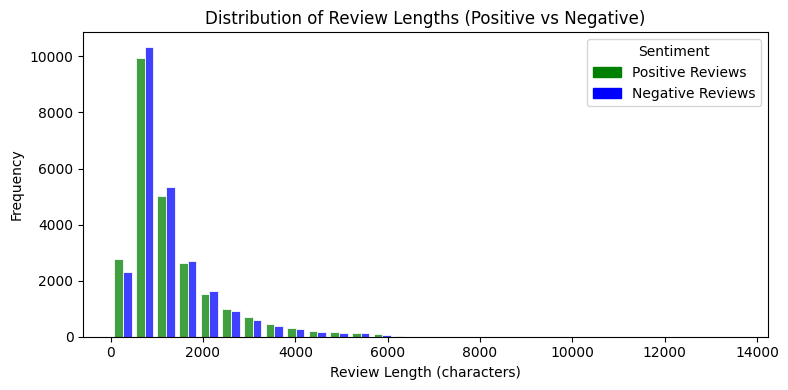

In [69]:
df['sentiment_label'] = df['sentiment'].map({1: 'Positive Reviews', 0: 'Negative Reviews'})
df['review_length'] = df['review'].str.len()

min_len = df['review_length'].min()
max_len = df['review_length'].max()
bins = np.linspace(min_len, max_len, 30)

plt.figure(figsize=(8,4))
ax = sns.histplot(
    data=df,
    x='review_length',
    hue='sentiment_label',
    bins=bins,
    multiple='dodge',
    shrink=0.8,
    palette={'Positive Reviews':'green','Negative Reviews':'blue'},
    legend=False,
    edgecolor='white'
)

pos_patch = mpatches.Patch(color='green', label='Positive Reviews')
neg_patch = mpatches.Patch(color='blue',  label='Negative Reviews')
ax.legend(handles=[pos_patch, neg_patch], title='Sentiment', loc='upper right')

ax.set_title('Distribution of Review Lengths (Positive vs Negative)')
ax.set_xlabel('Review Length (characters)')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()


First, we stripped the `<br />`s from the reviews as we did not want our models to train on them over the meaning of the text. We investigated the lengths of reviews and found little difference in the distribution of review length for positive and negative reviews (as shown above).

Another interesting thing to look at is the difference in punctuation frequency between review types. Specifically, we found the strongest differences in the number of question marks:

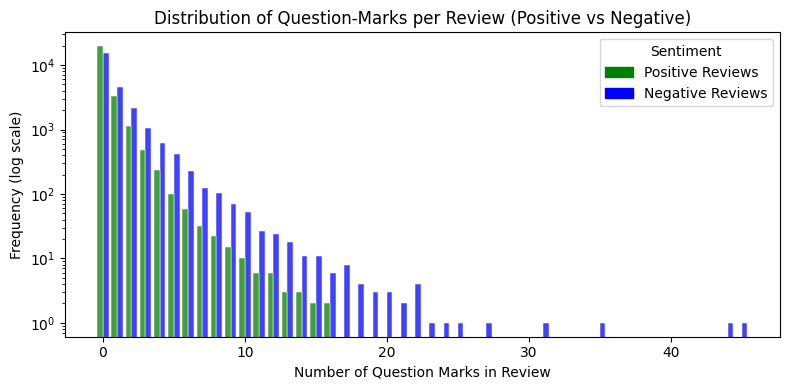

In [70]:
df['num_qmarks'] = df['review'].str.count(r'\?')

min_q = df['num_qmarks'].min()
max_q = df['num_qmarks'].max()
bins = np.arange(min_q, max_q+2)-0.5

plt.figure(figsize=(8, 4))
ax = sns.histplot(
    data=df,
    x='num_qmarks',
    hue='sentiment_label',
    bins=bins,
    multiple='dodge',
    shrink=0.8,
    palette={'Positive Reviews':'green', 'Negative Reviews':'blue'},
    legend=False,
    edgecolor='white'
)

pos_patch = mpatches.Patch(color='green', label='Positive Reviews')
neg_patch = mpatches.Patch(color='blue',  label='Negative Reviews')
ax.legend(handles=[pos_patch, neg_patch], title='Sentiment', loc='upper right')

ax.set_yscale('log')
ax.set_title('Distribution of Question-Marks per Review (Positive vs Negative)')
ax.set_xlabel('Number of Question Marks in Review')
ax.set_ylabel('Frequency (log scale)')

plt.tight_layout()
plt.show()

We see that all reviews over 16 question marks in this dataset are negative reviews, and on average, negative reviews tend to have more question marks than positive ones. To find some trends in the data, we examined the frequencies of the most common words in the reviews while excluding common stopwords. The results, depicted below, include generic words that one would expect to appear in movie reviews such as “film” or “character.”


In [71]:
all_reviews = df['review']

vectorizer_all = CountVectorizer(stop_words='english')
X_all = vectorizer_all.fit_transform(all_reviews)

word_counts_all = X_all.sum(axis=0).A1
vocab_all = vectorizer_all.get_feature_names_out()
word_freq_all = pd.Series(word_counts_all, index=vocab_all).sort_values(ascending=False).head(20)


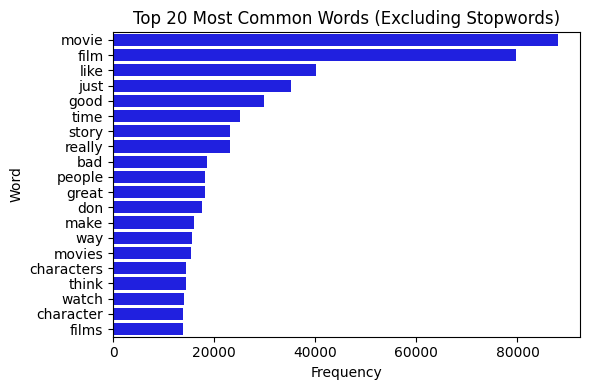

In [72]:
plt.figure(figsize=(6, 4))
sns.barplot(x=word_freq_all.values, y=word_freq_all.index, color='blue')
plt.title("Top 20 Most Common Words (Excluding Stopwords)")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

Next, we split the dataset into two dataframes, one for positive sentiment reviews and one for negative sentiment reviews. Then, we took the top 500 words in each, and removed the words that appeared in both lists, as we wanted to identify the most common words specific to either positive or negative sentiment reviews. The most common words in positive reviews consist of words that we typically associate with being positive like “excellent” and “wonderful”, while the most common words in negative reviews consist of words that we typically associate with being negative like “worst” or “awful”. Here are the top 15 distinctive words for each sentiment:


In [73]:
positive_reviews = df[df['sentiment'] == 1]['review']
negative_reviews = df[df['sentiment'] == 0]['review']

vectorizer = CountVectorizer(stop_words='english')
X_pos = vectorizer.fit_transform(positive_reviews)
X_neg = CountVectorizer(stop_words='english', vocabulary=vectorizer.vocabulary_).fit_transform(negative_reviews)

word_counts_pos = X_pos.sum(axis=0).A1
word_counts_neg = X_neg.sum(axis=0).A1
vocab = vectorizer.get_feature_names_out()

pos_freq = pd.Series(word_counts_pos, index=vocab).sort_values(ascending=False).head(500)
neg_freq = pd.Series(word_counts_neg, index=vocab).sort_values(ascending=False).head(500)

pos_unique = pos_freq[~pos_freq.index.isin(neg_freq.index)]
neg_unique = neg_freq[~neg_freq.index.isin(pos_freq.index)]

print("Top distinctive words in positive reviews:\n")
print(pos_unique[:15])

print("\nTop distinctive words in negative reviews:\n")
print(neg_unique[:15])


Top distinctive words in positive reviews:

excellent     3359
wonderful     2668
perfect       2434
loved         2239
amazing       2004
brilliant     1874
today         1867
favorite      1843
heart         1779
enjoyed       1719
highly        1701
strong        1511
hilarious     1408
experience    1393
simple        1368
dtype: int64

Top distinctive words in negative reviews:

worst            4888
awful            3143
poor             3027
boring           2997
stupid           2968
terrible         2902
waste            2611
worse            2479
supposed         2248
oh               2228
horrible         2183
unfortunately    1799
crap             1784
decent           1626
hour             1575
dtype: int64


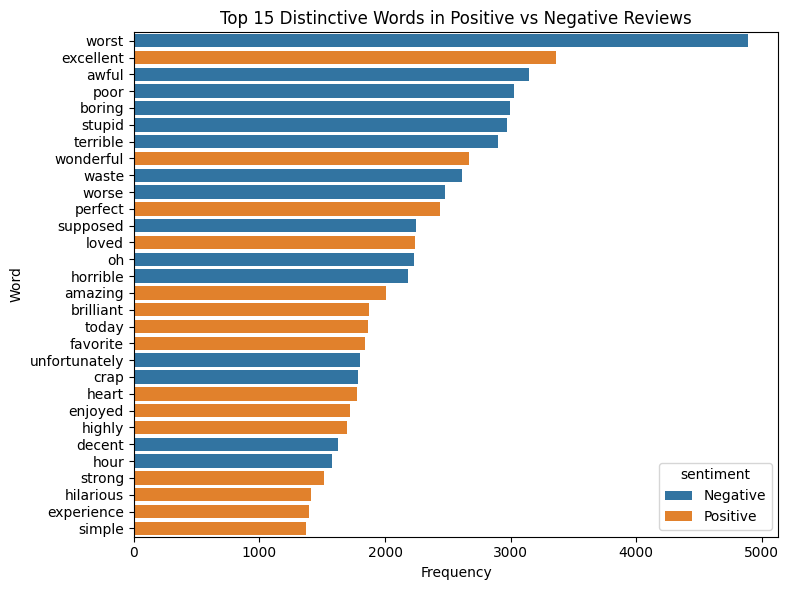

In [74]:
top_pos_unique = pos_unique.head(15)
top_neg_unique = neg_unique.head(15)

distinctive_df = pd.concat([
    pd.DataFrame({'word': top_pos_unique.index, 'count': top_pos_unique.values, 'sentiment': 'Positive'}),
    pd.DataFrame({'word': top_neg_unique.index, 'count': top_neg_unique.values, 'sentiment': 'Negative'})
])

distinctive_df = distinctive_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=distinctive_df, x='count', y='word', hue='sentiment', dodge=False)
plt.title("Top 15 Distinctive Words in Positive vs Negative Reviews")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()


We see that the most common negative words tend to be more common than the most common positive words, suggesting that people leaving negative reviews tend to use more of the same words than those leaving positive reviews.


# Baseline model: Bag of Words / Naive Bayes

Our baseline model was a naive Bayes classifier (IBM, Natural Language Toolkit). We split up the data into train and test data with 20% of the data being test data. Then, we used CountVectorizer from sklearn to vectorize the reviews as a bag of words. This ignores word order and relationships between words and learns to predict just based on word count.  We trained a MultinomialNB classifier on the vectorized data and ran inference on the test set. 

In [75]:
X = df['review']
y = df['sentiment']


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

model = MultinomialNB()
model.fit(X_train_bow, y_train)

y_pred = model.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8442

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      5035
           1       0.87      0.81      0.84      4965

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



The naive Bayes classifier achieved an accuracy of 84.4% on the test set. This shows that the words associated with positive and negative reviews are quite distinctive, and we expect more advanced models to be capable of achieving high test accuracy scores.

Below is the confusion matrix for the naive Bayes classifier. We can see that it predicts the negative class slightly more than the positive one, but overall the predictions are fairly balanced. This makes sense, given that the original dataset was balanced.


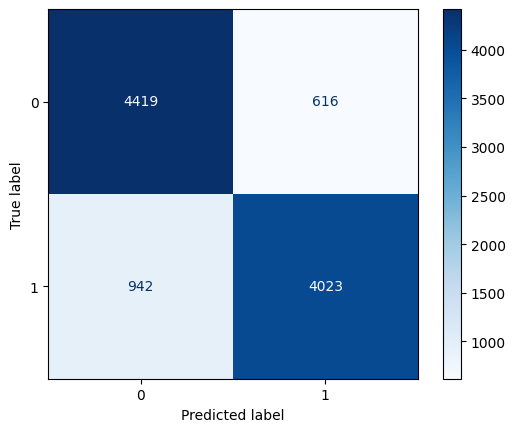

In [77]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")


In [78]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, ff_dim, dropout=0.1):
        super().__init__()
        # Single-head self-attention
        self.attention = nn.MultiheadAttention(embed_dim, num_heads=1, batch_first=True)
        self.attn_dropout = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        
        # Feed-forward network
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x, attention_mask=None):
        # Self-attention with residual connection and layer norm
        # For MultiheadAttention's key_padding_mask:
        # - True means position is masked (padding)
        # - False means position is attended to (actual tokens)
        key_padding_mask = None
        if attention_mask is not None:
            # Convert attention mask to the format expected by MultiheadAttention
            # HuggingFace masks use 1 for tokens and 0 for padding
            # We need to invert this for PyTorch's MultiheadAttention
            key_padding_mask = attention_mask.eq(0).to(dtype=torch.bool)
            
        attn_output, _ = self.attention(x, x, x, key_padding_mask=key_padding_mask)
        attn_output = self.attn_dropout(attn_output)
        x = self.norm1(x + attn_output)
        
        # Feed-forward with residual connection and layer norm
        ff_output = self.ff(x)
        x = self.norm2(x + ff_output)
        
        return x


In [79]:
class SentimentTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, ff_dim=512, num_layers=3, dropout=0.1, max_length=256):
        super().__init__()
        # Embedding layers
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Parameter(torch.zeros(1, max_length, embed_dim))
        self.embedding_dropout = nn.Dropout(dropout)
        self.embedding_norm = nn.LayerNorm(embed_dim)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, ff_dim, dropout) for _ in range(num_layers)
        ])
        self.block_dropout = nn.Dropout(dropout)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, 2)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)
            
    def forward(self, input_ids, attention_mask=None):
        # Get sequence length and apply embeddings
        seq_length = input_ids.size(1)
        x = self.token_embedding(input_ids)
        
        # Add positional embeddings
        pos_emb = self.position_embedding[:, :seq_length, :]
        x = x + pos_emb
        
        x = self.embedding_dropout(x)
        x = self.embedding_norm(x)
        
        # Apply transformer blocks
        for block in self.blocks:
            x = block(x, attention_mask)
            x = self.block_dropout(x)
        
        # Global mean pooling (excluding padding tokens)
        if attention_mask is not None:
            # Create mask for averaging (1 for tokens, 0 for padding)
            mask = attention_mask.float().unsqueeze(-1)
            x = (x * mask).sum(dim=1) / (mask.sum(dim=1) + 1e-9)
        else:
            x = x.mean(dim=1)
        
        # Apply classifier
        logits = self.classifier(x)
        return logits

In [80]:
SPLIT_DIR = "imdb_splits_90_10"
MODEL_NAME = "distilbert-base-uncased"
BATCH_SIZE = 16
MAX_LENGTH = 256
EMBED_DIM = 16
FF_DIM = 32
NUM_LAYERS = 2
DROPOUT = 0.3
NUM_EPOCHS = 5
LEARNING_RATE = 5e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [81]:
class IMDBJsonDataset(Dataset):
    def __init__(self, json_path: str, tokenizer, max_length: int):
        with open(json_path, "r") as f:
            self.examples = json.load(f)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        ex = self.examples[idx]
        encoding = self.tokenizer(
            ex["review"],
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
            add_special_tokens=True,
        )
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)
        label = torch.tensor(ex["label"], dtype=torch.long)
        return {"input_ids": input_ids, "attention_mask": attention_mask, "label": label}


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [82]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch in tqdm(loader, desc="  Training", leave=False):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

In [83]:
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="  Evaluating", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            total_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_ds = IMDBJsonDataset(os.path.join(SPLIT_DIR, "train.json"), tokenizer, MAX_LENGTH)
test_ds  = IMDBJsonDataset(os.path.join(SPLIT_DIR, "test.json"),  tokenizer, MAX_LENGTH)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

model = SentimentTransformer(
    vocab_size=tokenizer.vocab_size,
    embed_dim=EMBED_DIM,
    ff_dim=FF_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    max_length=MAX_LENGTH
).to(DEVICE)

print("Model Summary:")
print(model)
print(f"\nTotal trainable parameters: {count_parameters(model):,}\n")

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

train_losses, train_accs = [], []
test_losses,  test_accs  = [], []

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch {epoch}/{NUM_EPOCHS}")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    test_loss,  test_acc  = eval_one_epoch(model, test_loader,  criterion, DEVICE)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.2f}%\n")

print("train_losses: ", train_losses)
print("train_accs: ", train_accs)
print("test_losses: ", test_losses)
print("test_accs: ", test_accs)

Model Summary:
SentimentTransformer(
  (token_embedding): Embedding(30522, 16)
  (embedding_dropout): Dropout(p=0.3, inplace=False)
  (embedding_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
      )
      (attn_dropout): Dropout(p=0.3, inplace=False)
      (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=16, out_features=32, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.3, inplace=False)
        (3): Linear(in_features=32, out_features=16, bias=True)
        (4): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (block_dropout): Dropout(p=0.3, inplace=False)
  (classifier): Sequential(
    (0): LayerNorm((16,), eps=1e-05,

  Training:   0%|          | 0/1644 [00:00<?, ?it/s]

In [ ]:
epochs = list(range(1, NUM_EPOCHS + 1))

plt.figure()
plt.plot(epochs, train_losses, label="Train loss")
plt.plot(epochs, test_losses,  label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss by epoch")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, train_accs, label="Train accuracy")
plt.plot(epochs, test_accs,  label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Acc by epoch")
plt.legend()
plt.show()